In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import fibsem
from fibsem.imaging import masks
from fibsem.imaging import utils   
from autoscript_sdb_microscope_client.structures import AdornedImage
from PIL import Image
import logging
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import data
from skimage import filters
from skimage.color import rgb2gray
import imageio
import cv2
import glob
import itertools
import pandas as pd
from pprint import pprint
import plotly.express as px
import scipy
import statsmodels
import ipywidgets
from dataclasses import dataclass

In [4]:
def xcorr(
    img1: np.ndarray, 
    img2: np.ndarray, 
    use_mask: bool = True, 
    use_threshold: bool = True) -> np.ndarray:

    if img1.data.shape != img2.data.shape:
        err = f"Image 1 {img1.data.shape} and Image 2 {img2.data.shape} need to have the same shape"
        logging.error(err)
        raise ValueError(err)

    if use_mask:
        # Create Fourier Transform WITH Bandpass Filter
        pixelsize_img1 = img1.data.shape
        pixelsize_img2 = img2.data.shape
        img1_mask = masks.create_bandpass_mask(pixelsize_img1, 100, 4, 3)
        img2_mask = masks.create_bandpass_mask(pixelsize_img2, 100, 4, 3)
        img1fft = np.fft.ifftshift(img1_mask * np.fft.fftshift(np.fft.fft2(img1.data)))
        img2fft = np.fft.ifftshift(img2_mask * np.fft.fftshift(np.fft.fft2(img2.data)))
        assert img1_mask is not None, "Mask1 can not be None when using a Mask"
        assert img2_mask is not None, "Mask2 can not be None when using a Mask"

    else:
        # Create Fourier Transform
        img1fft = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(img1.data)))
        img2fft = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(img2.data)))

    # Do some shady normalization(?)
    n_pixels1 = img1.data.shape[0] * img1.data.shape[1]
    img1fft[0, 0] = 0
    tmp = img1fft * np. conj(img1fft)
    img1fft = n_pixels1 * img1fft / np.sqrt(tmp.sum())
    

    n_pixels2 = img2.data.shape[0] * img2.data.shape[1]
    img2fft[0, 0] = 0
    tmp = img2fft * np. conj(img2fft)
    img2fft = n_pixels2 * img2fft / np.sqrt(tmp.sum())


    if use_threshold:
        # Create threshold (Otsu's method) in abs Space
        abs1 = np.fft.fftshift(np.fft.ifftshift(np.fft.ifft2(img1fft)))
        abs2 = np.fft.fftshift(np.fft.ifftshift(np.fft.ifft2(img2fft)))
        otsu1 = filters.threshold_otsu(np.abs(abs1))
        otsu2 = filters.threshold_otsu(np.abs(abs2))

        # Create segmented binary Img
        binary1 = (abs1 > otsu1)*1
        binary2 = (abs2 > otsu2)*1
        
        # Back to Fourier Space for cross-correlation
        fft1 = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(binary1)))
        fft2 = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(binary2)))

        # Cross-correlate the two images
        corr = np.real(np.fft.fftshift(np.fft.ifft2(fft1 * np.conj(fft2))))

        # Cross-correlation center and shift from center
        maxX, maxY = np.unravel_index(np.argmax(corr), corr.shape)
        cen = np.asarray(corr.shape) / 2
        err = np.array(cen - [maxX, maxY], int)
        valMax = np.amax(corr)
        return corr, valMax, cen, err,

    else:
        # Cross-correlate the two images
        corr = np.real(np.fft.fftshift(np.fft.ifft2(img1fft * np.conj(img2fft))))
       
        # Cross-correlation center and shift from center
        maxX, maxY = np.unravel_index(np.argmax(corr), corr.shape)
        cen = np.asarray(corr.shape) / 2
        err = np.array(cen - [maxX, maxY], int)
        valMax = np.amax(corr)
        return corr, valMax, cen, err

In [5]:
# Load the data (consecutive pairs of EB/IB .tif images)
data1 = []
files = glob.glob("../xcorrtest/*.tif")
for file in files:
    img = mpimg.imread(file)
    img = AdornedImage(img, None)
    data1.append(img)
arr = np.array(data1)

# Create two arrays of the EB and IB imgs respectively
ebimg = arr[0:arr.size:2]
ibimg = arr[1:arr.size:2]

# Function to "tilt" the img (cosine stretch)
@dataclass
class Point:
    x: float = 0.0
    y: float = 0.0
def stretch(img, tilt_degrees):
    tilt = np.deg2rad(tilt_degrees)
    shape = int(img.shape[0] / np.cos(tilt)), int(img.shape[1] / np.cos(tilt))
    resized_img = np.asarray(Image.fromarray(img).resize(size=(shape[1], shape[0])))
    c = Point(resized_img.shape[1]//2, resized_img.shape[0]//2)
    dy, dx = img.shape[0]//2, img.shape[1]//2
    scaled_img = resized_img[c.y-dy:c.y+dy, c.x-dx:c.x+dx]
    return scaled_img

# Create tilted IB(!) imgs (25° stretch)
tilter = []
for i in range(int(arr.size / 2)):
    cos = stretch(ibimg[i].data, 25)
    tilter.append(cos)
tilted = np.array(tilter)

In [6]:
'''Create dictionary and DataFrame for xcorr data
Outputs 4x the images with Mask & Threshold, True & False respectively'''
dict_list1 = []
for i in range(int(arr.size / 2)):
    for use_mask in [True, False]:
        for use_threshold in [True, False]:
            corr1, maxVal1, cen1, err1 = xcorr(ebimg[i], ibimg[i], use_mask, use_threshold)
            data_dict1 = {
            "n":i, 
            "use_mask":use_mask, 
            "use_threshold":use_threshold,
            "corr1":corr1, 
            "maxVal1":maxVal1, 
            "cen1":cen1, 
            "err1_x":err1[0], 
            "err1_y":err1[1]}
            dict_list1.append(data_dict1)
df1 = pd.DataFrame.from_dict(dict_list1)

In [7]:
#Create the same DataFrame but for the TILTED IB imgs
dict_list2 = []
for i in range(int(arr.size / 2)):
    for use_mask in [True, False]:
        for use_threshold in [True, False]:
            corr2, maxVal2, cen2, err2 = xcorr(ebimg[i], tilted[i], use_mask, use_threshold)
            data_dict2 = {
            "n":i, 
            "use_mask":use_mask, 
            "use_threshold":use_threshold,
            "corr2":corr2, 
            "maxVal2":maxVal2, 
            "cen2":cen2, 
            "err2_x":err2[0], 
            "err2_y":err2[1]}
            dict_list2.append(data_dict2)
df2 = pd.DataFrame.from_dict(dict_list2)

In [103]:
df_errx = []
df_erry = []
for i in range(80):
    df_errx.append(df1["err1_x"].iloc[i])
    df_erry.append(df1["err1_y"].iloc[i])
    
order_errx = np.array(df_errx)  
order_erry = np.array(df_erry)

errx_tt = order_errx[0:order_errx.size:4]
errx_tf = order_errx[1:order_errx.size:4]
errx_ft = order_errx[2:order_errx.size:4]
errx_ff = order_errx[3:order_errx.size:4]
erry_tt = order_erry[0:order_erry.size:4]
erry_tf = order_erry[1:order_erry.size:4]
erry_ft = order_erry[2:order_erry.size:4]
erry_ff = order_erry[3:order_erry.size:4]

true_true = []
true_false = []
false_true = []
false_false = []
for i in range(20):
    true_true.append(np.roll(ibimg[i].data, shift=(-errx_tt[i], -erry_tt[i]), axis=(0, 1)))
    true_false.append(np.roll(ibimg[i].data, shift=(-errx_tf[i], -erry_tf[i]), axis=(0, 1)))
    false_true.append(np.roll(ibimg[i].data, shift=(-errx_ft[i], -erry_ft[i]), axis=(0, 1)))
    false_false.append(np.roll(ibimg[i].data, shift=(-errx_ff[i], -erry_ff[i]), axis=(0, 1)))

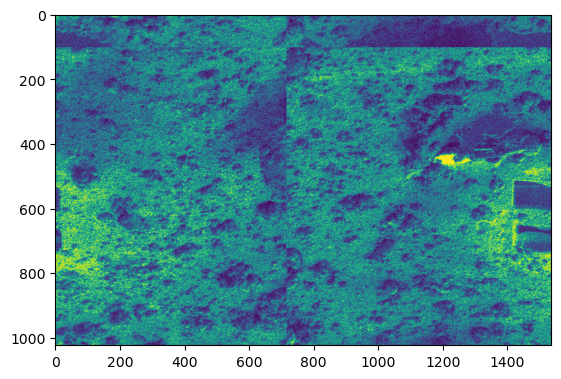

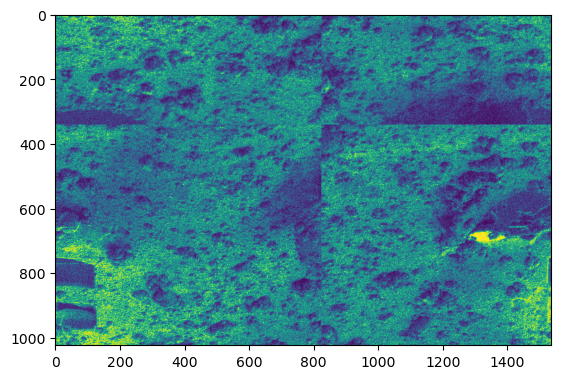

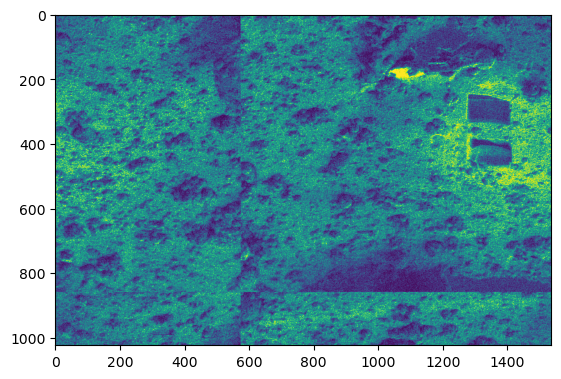

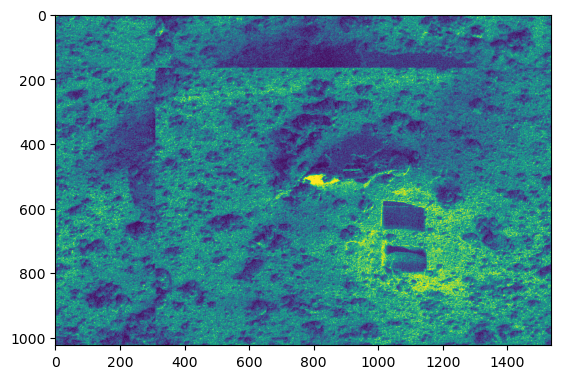

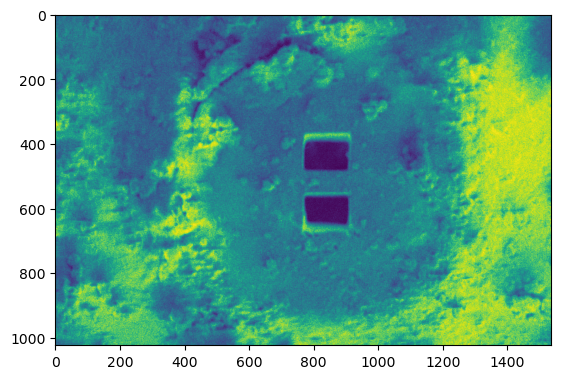

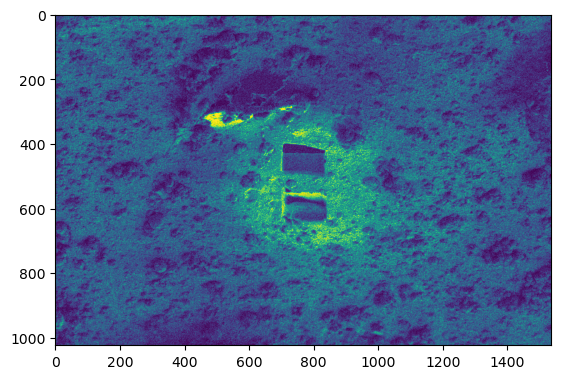

In [39]:
plt.imshow(ebimg[1].data)
plt.show()
plt.imshow(ibimg[1].data)
    


# np.roll(img2.data, shift=(-err[0], -err[1]), axis=(0, 1))